In [17]:
import scanpy as sc
import snapatac2 as snap
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import matplotlib.colors as mcolors

In [2]:
import polars as pl

In [3]:
adata = snap.read_dataset("/gpfs/commons/groups/zhu_lab/zcao/Paired_damage/data/SnapATAC2_whitelist/merged_whitelist.h5ad")
adata

AnnDataSet object with n_obs x n_vars = 64775 x 606219 backed at '/gpfs/commons/groups/zhu_lab/zcao/Paired_damage/data/SnapATAC2_whitelist/merged_whitelist.h5ad'
contains 6 AnnData objects with keys: 'Ctrl', '0hr', '2hr', '6hr', '24hr', '48hr'
    obs: 'Treatment', 'RNA_anno', 'Phase', 'barcodes'
    uns: 'macs3', 'reference_sequences', 'AnnDataSet'

In [4]:
groups = ['Ctrl',
 '0hr',
 '2hr',
 '6hr',
 '24hr',
 '48hr']

In [5]:
FixedWidth_out = "/gpfs/commons/groups/zhu_lab/zcao/Paired_damage/data/Joint_finalist/FixWidth/"
VarWidth_out = "/gpfs/commons/groups/zhu_lab/zcao/Paired_damage/data/Joint_finalist/VarWidth/"

In [6]:
peaks_dict = {}

data_dir="/gpfs/commons/groups/zhu_lab/zcao/Paired_damage/data/MACS3_downsample/filtered_blacklist/"
for t in groups:
    # Read the DataFrame from a CSV file
    df = pd.read_csv("{}/{}_valueFixed_peaks.narrowPeak".format(data_dir, t), 
                     sep="\t", 
                     header=None)
    df[3] = "."
    df.columns = ['chrom', 'start', 'end', 'name', 'score', 'strand', 'signal_value',
                  'p_value', 'q_value', 'peak']
    
    # Convert the pandas DataFrame to a polars DataFrame without pre-conversion of types in pandas
    df_pl = pl.from_pandas(df)

    # Now, ensure specific data types in Polars if needed. For example:
    df_pl = df_pl.with_columns([
        df_pl['chrom'].cast(pl.Utf8),
        df_pl['start'].cast(pl.UInt64),
        df_pl['end'].cast(pl.UInt64),
        df_pl['name'].cast(pl.Utf8),
        df_pl['score'].cast(pl.UInt16),
        df_pl['strand'].cast(pl.Utf8),
        df_pl['signal_value'].cast(pl.Float64),
        df_pl['p_value'].cast(pl.Float64),
        df_pl['q_value'].cast(pl.Float64),
        df_pl['peak'].cast(pl.UInt64),
    ])
    df_pl = df_pl.filter(pl.col('chrom').is_in(snap.genome.hg38.chrom_sizes.keys()))
    # Add the polars DataFrame to the dictionary with the celltype as the key
    peaks_dict[t] = df_pl

# Store the dictionary in adata.uns under the key 'macs3'
adata.uns['macs3'] = peaks_dict

/scratch/ipykernel_23993/405219594.py:34: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  adata.uns['macs3'] = peaks_dict
/scratch/ipykernel_23993/405219594.py:34: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  adata.uns['macs3'] = peaks_dict


In [7]:
peaks = snap.tl.merge_peaks(adata.uns['macs3'], snap.genome.hg38, half_width = 600)

In [8]:
peaks.shape

(102705, 7)

In [9]:
peaks.head()

shape: (5, 7)
┌────────────────────┬───────┬───────┬───────┬───────┬───────┬───────┐
│ Peaks              ┆ 48hr  ┆ 2hr   ┆ 6hr   ┆ Ctrl  ┆ 0hr   ┆ 24hr  │
│ ---                ┆ ---   ┆ ---   ┆ ---   ┆ ---   ┆ ---   ┆ ---   │
│ str                ┆ bool  ┆ bool  ┆ bool  ┆ bool  ┆ bool  ┆ bool  │
╞════════════════════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╡
│ chr1:804176-805377 ┆ false ┆ false ┆ false ┆ true  ┆ false ┆ false │
│ chr1:819895-821096 ┆ true  ┆ true  ┆ true  ┆ true  ┆ true  ┆ true  │
│ chr1:822083-823284 ┆ true  ┆ true  ┆ true  ┆ true  ┆ true  ┆ true  │
│ chr1:853078-854279 ┆ false ┆ true  ┆ false ┆ false ┆ false ┆ false │
│ chr1:856180-857381 ┆ true  ┆ true  ┆ true  ┆ true  ┆ true  ┆ true  │
└────────────────────┴───────┴───────┴───────┴───────┴───────┴───────┘

In [10]:
peak_mat = snap.pp.make_peak_matrix(adata, use_rep=peaks['Peaks'])
peak_mat

/gpfs/commons/home/zcao/.conda/envs/scpy/lib/python3.9/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 64775 × 102705
    obs: 'Treatment', 'RNA_anno', 'Phase', 'barcodes'

In [11]:
marker_peaks = snap.tl.marker_regions(peak_mat, groupby='Treatment', pvalue=0.01)

In [12]:
marker_peaks

{}

In [13]:
sc.pp.calculate_qc_metrics(
    peak_mat, expr_type = "read", var_type = "InPeak", percent_top=None, log1p=False, inplace=True
)

In [14]:
sc.settings.figdir = "/gpfs/commons/groups/zhu_lab/zcao/Paired_damage/data/Joint_finalist/FixWidth/downsample/"

In [18]:
num_colors = 6
cmap = plt.get_cmap('plasma')
colors = [mcolors.to_hex(cmap(i)) for i in np.linspace(0, 1, num_colors)]
peak_mat.uns["Treatment_colors"] = colors

In [19]:
sc.settings.set_figure_params(
    dpi=500, dpi_save=1000, figsize=(10, 5))
sc.pl.violin(
    peak_mat,
    ["n_InPeak_by_read", "total_read"],
    jitter=0,
    groupby = "Treatment", 
    inner = "box", 
    multi_panel=True,
    col = peak_mat.uns["Treatment_colors"], 
    save = "_ReadInPeak.pdf"
)

In [20]:
damage_ad = adata.to_adata()

In [24]:
peak_mat.obs["FRiP"] = peak_mat.X.sum(1)/damage_ad.X.sum(1)

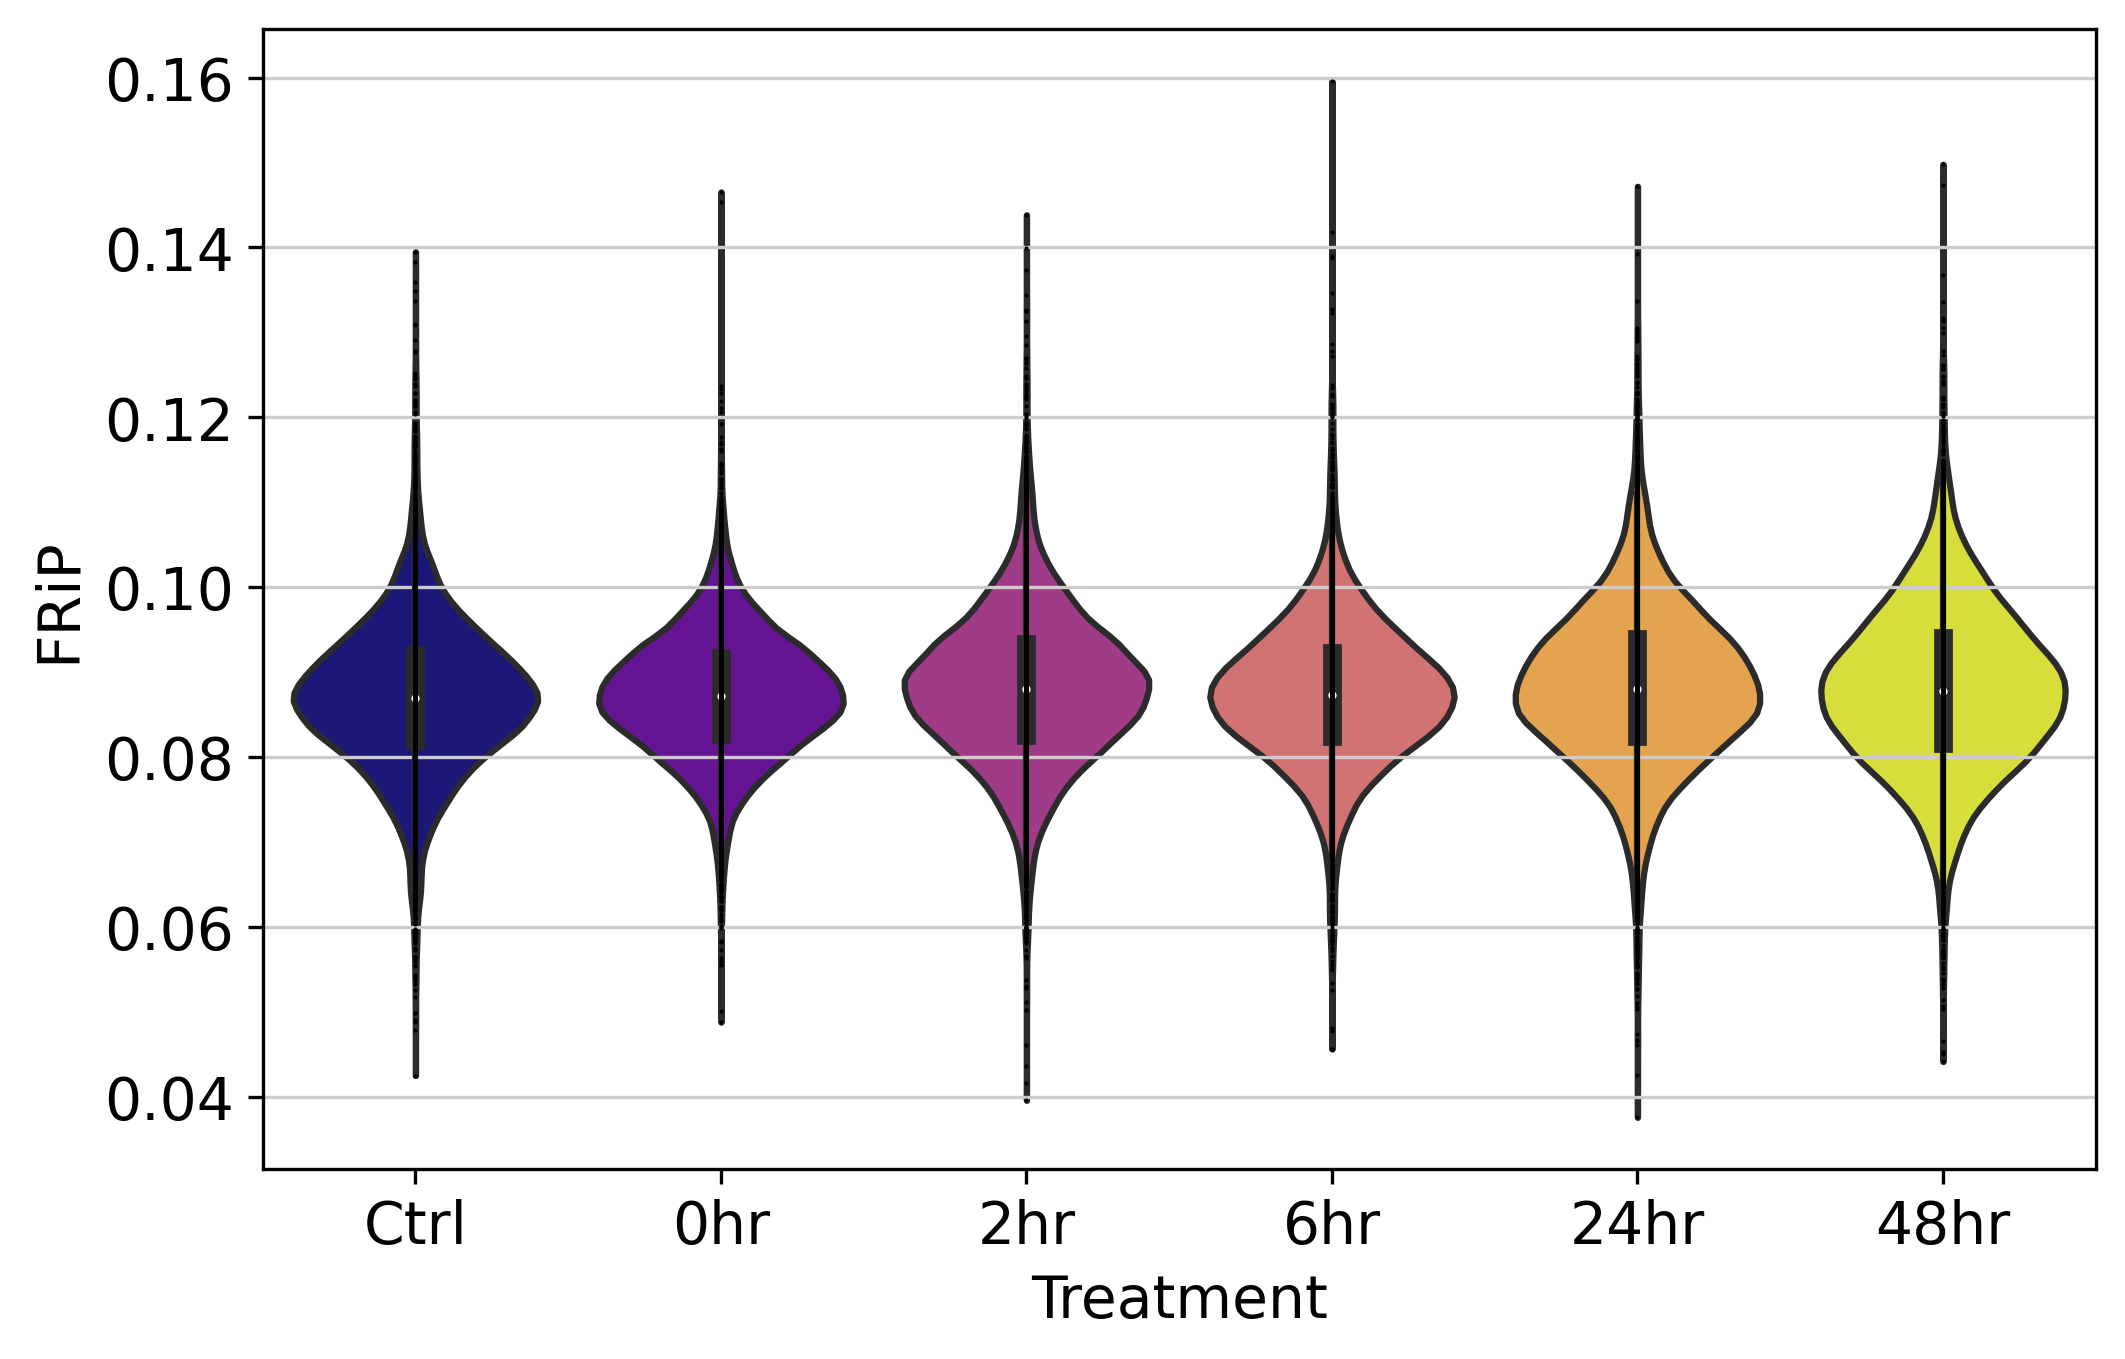

In [25]:
sc.settings.set_figure_params(
    dpi=150, dpi_save=1000, figsize=(7, 5))
sc.pl.violin(
    peak_mat,
    ["FRiP"],
    jitter=0,
    groupby = "Treatment", 
    col = peak_mat.uns["Treatment_colors"], 
    inner = "box", 
    save = "_FRiP_Treatment.pdf"
)

In [27]:
peak_mat.write("/gpfs/commons/groups/zhu_lab/zcao/Paired_damage/data/Joint_finalist/PeakMat_downsample_FixedLength_040824.h5ad")

In [29]:
#get the metacell object
import SEACells

def celltype_frac(x, col_name):
    """TODO."""
    val_counts = x[col_name].value_counts()
    return val_counts.values[0] / val_counts.values.sum()

def compute_celltype_purity(ad, col_name):
    """Compute the purity (prevalence of most abundant value) of the specified col_name from ad.obs within each metacell.

    @param: ad - AnnData object with SEACell assignment and col_name in ad.obs dataframe
    @param: col_name - (str) column name within ad.obs representing celltype groupings for each cell.
    """
    celltype_fraction = ad.obs.groupby("SEACell").apply(
        lambda x: celltype_frac(x, col_name)
    )
    celltype = ad.obs.groupby("SEACell").apply(
        lambda x: x[col_name].value_counts().index[0]
    )

    return pd.concat([celltype, celltype_fraction], axis=1).rename(
        columns={0: col_name, 1: f"{col_name}_purity"}
    )
    
def summarize_by_SEACell_average(
    ad, SEACells_label="SEACell", celltype_label=None, summarize_layer="raw"
):

    import scanpy as sc
    import numpy as np
    import pandas as pd
    from scipy.sparse import csr_matrix
    from tqdm.auto import tqdm

    # Set of metacells
    metacells = ad.obs[SEACells_label].unique()

    # Summary matrix for averages
    avg_matrix = pd.DataFrame(0.0, index=metacells, columns=ad.var_names)

    for m in tqdm(avg_matrix.index):
        cells = ad.obs_names[ad.obs[SEACells_label] == m]
        cell_count = len(cells)  # Number of cells in the metacell for averaging
        if summarize_layer == "X":
            avg_matrix.loc[m, :] = np.ravel(ad[cells, :].X.sum(axis=0)) / cell_count
        elif summarize_layer == "raw" and ad.raw is not None:
            avg_matrix.loc[m, :] = np.ravel(ad[cells, :].raw.X.sum(axis=0)) / cell_count
        else:
            avg_matrix.loc[m, :] = np.ravel(
                ad[cells, :].layers[summarize_layer].sum(axis=0)
            ) / cell_count

    # Ann data for averages
    meta_ad = sc.AnnData(csr_matrix(avg_matrix), dtype=csr_matrix(avg_matrix).dtype)
    meta_ad.obs_names, meta_ad.var_names = avg_matrix.index.astype(str), ad.var_names
    meta_ad.layers["raw"] = csr_matrix(avg_matrix)

    # Also compute cell type purity if label is provided
    if celltype_label is not None:
        try:
            # Assuming evaluate.compute_celltype_purity is a function you have access to
            purity_df = compute_celltype_purity(ad, celltype_label)
            meta_ad.obs = meta_ad.obs.join(purity_df)
        except Exception as e:
            print(f"Cell type purity calculation failed with Exception: {e}")

    return meta_ad

In [30]:
import pickle
dir = "/gpfs/commons/groups/zhu_lab/zcao/Paired_damage/analysis/RNA/SEACells/model300_trained.pkl" #model 150 or 1000
with open(dir, 'rb') as f:
    # Load the pickled object from the file
    model = pickle.load(f)

In [32]:
hard_assignment = model.get_hard_assignments()
hard_assignment.index.name = None
hard_assignment.head()

SEACell
01_A1:AN:01  SEACell-182
01_A1:B1:03  SEACell-195
01_A1:BE:04   SEACell-43
01_A1:C1:02  SEACell-182
01_A1:DI:02   SEACell-74

In [31]:
peak_mat = peak_mat[peak_mat.obs["RNA_anno"] != "ZC3HAV1"]

In [33]:
peak_mat.obs = peak_mat.obs.join(hard_assignment)

In [35]:
peak_mat.obs.head()

Treatment     RNA_anno Phase     barcodes  n_InPeak_by_read  \
01_A1:AN:01      Ctrl   Early_FGF2    G1  01_A1:AN:01                74   
01_A1:C1:02      Ctrl   Early_FGF2   G2M  01_A1:C1:02               361   
01_A1:DI:02      Ctrl   Early_FGF2   G2M  01_A1:DI:02               508   
01_A1:HR:02      Ctrl   Early_NEK7     S  01_A1:HR:02               354   
01_A1:JE:02      Ctrl  Early_EPHA7   G2M  01_A1:JE:02               574   

             total_read      FRiP      SEACell  
01_A1:AN:01         106  0.087531  SEACell-182  
01_A1:C1:02         558  0.081603  SEACell-182  
01_A1:DI:02         747  0.083111   SEACell-74  
01_A1:HR:02         539  0.087771   SEACell-13  
01_A1:JE:02         888  0.092916   SEACell-25

In [36]:
damage_meta = summarize_by_SEACell_average(peak_mat, celltype_label = "RNA_anno", summarize_layer = "X") 
damage_meta

  0%|          | 0/213 [00:00<?, ?it/s]

/gpfs/commons/home/zcao/.conda/envs/scpy/lib/python3.9/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 213 × 102705
    obs: 'RNA_anno', 'RNA_anno_purity'
    layers: 'raw'

In [37]:
Treatment_purity = compute_celltype_purity(peak_mat, "Treatment")
Treatment_purity.head()

Treatment  Treatment_purity
SEACell                                
SEACell-0         6hr          0.954023
SEACell-1        48hr          0.758333
SEACell-10        6hr          0.913462
SEACell-100       2hr          0.866667
SEACell-101      24hr          0.853659

In [38]:
damage_meta.obs = damage_meta.obs.join(Treatment_purity)
damage_meta

AnnData object with n_obs × n_vars = 213 × 102705
    obs: 'RNA_anno', 'RNA_anno_purity', 'Treatment', 'Treatment_purity'
    layers: 'raw'

In [40]:
sc.pp.calculate_qc_metrics(
    damage_meta, expr_type = "read", var_type = "InPeak", percent_top=None, log1p=False, inplace=True
)

In [42]:
damage_meta.uns["Treatment_colors"] = colors

In [43]:
sc.settings.set_figure_params(
    dpi=500, dpi_save=1000, figsize=(10, 5))
sc.pl.violin(
    damage_meta,
    ["n_InPeak_by_read", "total_read"],
    jitter=0,
    groupby = "Treatment", 
    inner = "box", 
    multi_panel=True,
    col = peak_mat.uns["Treatment_colors"], 
    save = "_ReadInPeak_meta.pdf"
)

In [44]:
damage_meta.write("/gpfs/commons/groups/zhu_lab/zcao/Paired_damage/data/SEACells/model300/DamagePeak_FixedLen_DS_040824.h5ad")